## 문제점&해결책
1. 손가락 인식문제 -> mediapipe

2. 손가락을 추적하여 그림그리기 -> 손가락의 좌표를 저장하여 좌표들을 이어줌

3. 좌표값이 내가 만든 보드와 맞지않음 -> mediapipe의 x,y 좌표를 화이트보드 크기만큼 곱해줌

4. 그림을 초기화 시켜야하는데 초기화가 안됨 -> 그림그리는 함수의 for문의 조건에 맞지않아 for문이 시행이 안돼 초기화가 안됨, for문 앞에 if문으로 조건을 만들어 초기화 시킴

5. 손동작으로 다 그림도 그리고 프로그램도 종료하고 했더니 그림그리기 어려워지고 잘못인식하여 프로그램이 종료되는 경우가 생김 -> 키보드 활용

6. 내가 그린 그림의 숫자가 인식이 안됨 -> 학습모델의 input이 28 by 28이기 때문에 화이트 보드의 크기가 480 by 600의 크기를 사이즈를 28 by 28줄이니 데이터의 손실이 발생 -> 애초에 28 by 28 크기의 보드로 바꿔줌 -> 데이터 손실이 없어 정확도 상승

7. 손가락이 너무 두껍게 인식되서 그림 그리기가 힘들고 조금만 못그려도 예상과 다른 결과가 나옴 -> 학습데이터 크기를 키워 문제점 해결 하지만 100 by 100정도가   한계 200 by 200 시 메모리 초과 발생 학습시간 매우증가

## 라이브러리 사용

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

import cv2
import numpy as np
import sys
import pandas as pd

import os
import numpy
import matplotlib.pyplot as plt

## 학습모델 만들기_1

In [22]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 784).astype('float32')/255
x_test = x_test.reshape(x_test.shape[0],784).astype('float32')/255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

model_1 = Sequential()
model_1.add(Dense(512, input_dim = 784, activation = 'relu'))
model_1.add(Dense(10, activation = 'softmax'))

model_1.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience = 10)

history = model_1.fit(x_train,y_train, validation_data=(x_test, y_test),
                   epochs = 30, batch_size=100, 
                   callbacks = [early_stopping_callback])

print('\n Test Accuracy: %.4f' % (model_1.evaluate(x_test,y_test)[1]))

Epoch 1/30
600/600 [==============================] - 5s 6ms/step - loss: 0.2515 - accuracy: 0.9286 - val_loss: 0.1219 - val_accuracy: 0.9642
Epoch 2/30
600/600 [==============================] - 4s 6ms/step - loss: 0.1015 - accuracy: 0.9707 - val_loss: 0.0906 - val_accuracy: 0.9738
Epoch 3/30
600/600 [==============================] - 3s 5ms/step - loss: 0.0656 - accuracy: 0.9802 - val_loss: 0.0738 - val_accuracy: 0.9776
Epoch 4/30
600/600 [==============================] - 3s 5ms/step - loss: 0.0457 - accuracy: 0.9866 - val_loss: 0.0649 - val_accuracy: 0.9789
Epoch 5/30
600/600 [==============================] - 3s 5ms/step - loss: 0.0337 - accuracy: 0.9897 - val_loss: 0.0622 - val_accuracy: 0.9809
Epoch 6/30
600/600 [==============================] - 3s 5ms/step - loss: 0.0247 - accuracy: 0.9932 - val_loss: 0.0651 - val_accuracy: 0.9782
Epoch 7/30
600/600 [==============================] - 3s 6ms/step - loss: 0.0188 - accuracy: 0.9948 - val_loss: 0.0646 - val_accuracy: 0.9793
Epoch 

## (손동작을로 그림그리고 손동작으로 종료) 문제 1

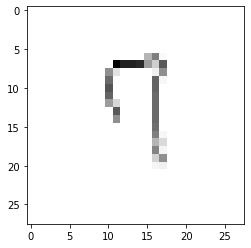

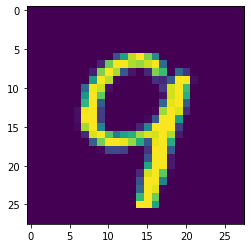

In [92]:
import cv2
import mediapipe as mp
import numpy as np


(i_train, j_train),(i_test, j_test) = mnist.load_data()
num_class = [i_test[10], i_test[2], i_test[1], i_test[30], i_test[24],
            i_test[15], i_test[21], i_test[0], i_test[61], i_test[16]]

sw = 0
sample = []
def draw_ball_location(img, locations):
    global sw
    
    if len(locations) == 0 and sw == 1:
        img = np.ones((480, 640, 3), np.uint8)*0
        sw = 0
    for i in range(len(locations)-1):
            
        cv2.line(img, tuple(locations[i]), 
                tuple(locations[i+1]), (0, 255, 0), 3)

    sample.append(img)
    return img


img = np.ones((480, 640, 3), np.uint8)*0


max_num_hands = 1
gesture = {
    0:'fist', 1:'one', 2:'two', 3:'three', 4:'four', 5:'five',
    6:'six', 7:'rock', 8:'spiderman', 9:'yeah', 10:'ok',
}
rps_gesture = {0:'rock', 5:'paper',1:'write',10:'stop',6:'clear'}

# MediaPipe hands model
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands=max_num_hands,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# Gesture recognition model
file = np.genfromtxt('./rsp_train/gesture_train.csv', delimiter=',')
angle = file[:,:-1].astype(np.float32)
label = file[:, -1].astype(np.float32)
knn = cv2.ml.KNearest_create()
knn.train(angle, cv2.ml.ROW_SAMPLE, label)

cap = cv2.VideoCapture(0)

list_ball_location = []
history_ball_locations = []
isDraw = True

while cap.isOpened():
    ret, image = cap.read()
    result = hands.process(image)
    if not ret:
        continue

    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    result = hands.process(image)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
 
    
    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:

            joint = np.zeros((21, 3))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z]

            # Compute angles between joints
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:]
            #Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:]
            # Child joint
            v = v2 - v1 # [20,3]
            # Normalize v
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # Convert radian to degree

            # Inference gesture
            data = np.array([angle], dtype=np.float32)
            ret, results, neighbours, dist = knn.findNearest(data,3 )
            idx = int(results[0][0])

            # Draw gesture result
            if idx in rps_gesture.keys():
                cv2.putText(image, text=rps_gesture[idx].upper(),
                            org=(int(res.landmark[0].x * img.shape[1]),
                                 int(res.landmark[0].y * img.shape[0] + 20)),
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                            color=(255, 255, 255), thickness=2)
            

            finger2_1 = int(res.landmark[8].x*600 )
            finger2_2 = int(res.landmark[8].y*480 )

            cv2.putText(
                image, text='f2_x=%d f2_y=%d ' % (finger2_1,
                                                      finger2_2), 
                org=(10, 30),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                color=255, thickness=3)

            mp_drawing.draw_landmarks(
                image, res, mp_hands.HAND_CONNECTIONS)

            if isDraw:
                list_ball_location.append((finger2_1, finger2_2))

            else:
                history_ball_locations.append(list_ball_location.copy())
                list_ball_location.clear()
        
        
        if idx == 1:
            img = draw_ball_location(img, list_ball_location)
            for ball_locations in history_ball_locations:
                img = draw_ball_location(img, ball_locations)


        elif idx == 10:
            isDraw = not isDraw
            for ball_locations in history_ball_locations:
                img = draw_ball_location(img, ball_locations)
                
        elif idx == 6:
            list_ball_location.clear()
            history_ball_locations.clear()
            sw = 1
            img = draw_ball_location(img, list_ball_location)
            


        elif idx == 5:
            cap.release()
            cv2.destroyAllWindows()
            break

        else:      
            for ball_locations in history_ball_locations:
                img = draw_ball_location(img, ball_locations)

        mp_drawing.draw_landmarks(image, res, mp_hands.HAND_CONNECTIONS)
    
    cv2.imshow('img',img)
    cv2.imshow('Game', image)
    if cv2.waitKey(1) == ord('q'):
        break

cv2.imwrite('save_image.jpg', img)       
cap.release()
cv2.destroyAllWindows()

## 그린것을 읽어와 만든 학습모델로 예측하기
img = cv2.imread('./save_image.jpg', cv2.IMREAD_GRAYSCALE)
dst = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_AREA)
plt.imshow(dst, cmap = 'Greys')
plt.show()
data = dst.reshape(-1,784)
j = model_1.predict(data)
idx = np.argmax(j)
plt.imshow(num_class[idx])
plt.show()
# 인식을 잘 하지 못함 이유 -> 이미지 축소하면서 데이터가 많이 손실됨

In [74]:
model_1.evaluate(x_train,y_train)[1]

1875/1875 [==============================] - 5s 3ms/step - loss: 0.0019 - accuracy: 0.9995


0.9995166659355164

## (손동작으로 그림그리고 키보드로 종료) 문제 2

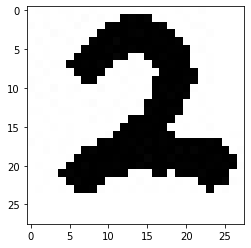

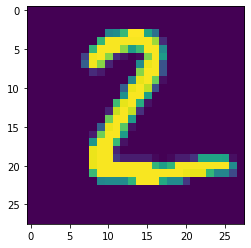

In [90]:
import cv2
import mediapipe as mp
import numpy as np
import sys

(i_train, j_train),(i_test, j_test) = mnist.load_data()
num_class = [i_test[10], i_test[2], i_test[1], i_test[30], i_test[24],
            i_test[15], i_test[21], i_test[0], i_test[61], i_test[16]]

sw = 0
sample = []
def draw_ball_location(img, locations):
    global sw
    
    if len(locations) == 0 and sw == 1:
        img = np.ones((28, 28, 3), np.uint8)*0
        sw = 0
    for i in range(len(locations)-1):
            
        cv2.line(img, tuple(locations[i]), 
                tuple(locations[i+1]), (255, 255, 255), 3)

    sample.append(img)
    return img

img = np.ones((28, 28, 3), np.uint8)*0


mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
 
cap = cv2.VideoCapture(0)


with mp_hands.Hands(
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    
    list_ball_location = []
    history_ball_locations = []
    isDraw = True
    while cap.isOpened():
        
        success, image = cap.read()
        
        
        if not success:
            continue
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
 
        results = hands.process(image)
 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:

            for hand_landmarks in results.multi_hand_landmarks:
                
                finger2_1 = int(hand_landmarks.landmark[8].x*28 )
                finger2_2 = int(hand_landmarks.landmark[8].y*28 )

                cv2.putText(
                    image, text='f2_x=%d f2_y=%d ' % (finger2_1,
                                                          finger2_2), 
                    org=(10, 30),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                    color=255, thickness=3)
 
                mp_drawing.draw_landmarks(
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                if isDraw:
                    list_ball_location.append((finger2_1, finger2_2))

                else:
                    history_ball_locations.append(list_ball_location.copy())
                    list_ball_location.clear()
        
        img = draw_ball_location(img, list_ball_location)
        for ball_locations in history_ball_locations:
            img = draw_ball_location(img, ball_locations)
        
        dst2 = cv2.resize(img, None,  None, 10, 10, 
                          interpolation = cv2.INTER_LINEAR)
        cv2.imshow('img', dst2)
        cv2.imshow('image', image)
        key = cv2.waitKey(1)
        
        if key == 27: # esc
            break
        
        elif key == 32: # space bar
            print('32')
            list_ball_location.clear()
            history_ball_locations.clear()
            sw = 1
            
        
        elif key == ord('v'):
            isDraw = not isDraw

cv2.imwrite('save_image.jpg', img)           
cap.release()
cv2.destroyAllWindows()

## 그린것을 읽어와 만든 학습모델로 예측하기
img = cv2.imread('./save_image.jpg', cv2.IMREAD_GRAYSCALE)
dst = img
plt.imshow(dst, cmap = 'Greys')
plt.show()
data = dst.reshape(-1 , 784).astype('float32')/255
j = model_1.predict(data)
idx = np.argmax(j)
plt.imshow(num_class[idx])
plt.show()

## 학습모델 만들기_2

In [12]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_arr = []
for x in x_train:
    x = cv2.resize(x,dsize = (100,100), interpolation = cv2.INTER_LINEAR)
    x_arr.append(x)
    
x_varr = []
for x_v in x_test:
    x_v = cv2.resize(x_v,dsize = (100,100), interpolation = cv2.INTER_LINEAR)
    x_varr.append(x_v)
    
x_arr = np.array(x_arr)
x_arr = x_arr.reshape(60000, 100**2).astype('float32')/255

x_varr = np.array(x_varr)
x_varr = x_varr.reshape(10000, 100**2).astype('float32')/255

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

model = Sequential()
model.add(Dense(512, input_dim = 100**2, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

early_stopping_callback = EarlyStopping(monitor='loss', patience = 10)

history = model.fit(x_arr,y_train, validation_data=(x_varr, y_test),
                   epochs = 30, batch_size=100,
                   callbacks = [early_stopping_callback])

print('\n Test Accuracy: %.4f' % (model.evaluate(x_varr,y_test)[1]))

Epoch 1/30
600/600 [==============================] - 23s 38ms/step - loss: 0.2056 - accuracy: 0.9383 - val_loss: 0.1135 - val_accuracy: 0.9656
Epoch 2/30
600/600 [==============================] - 23s 38ms/step - loss: 0.0922 - accuracy: 0.9713 - val_loss: 0.0814 - val_accuracy: 0.9751
Epoch 3/30
600/600 [==============================] - 21s 35ms/step - loss: 0.0648 - accuracy: 0.9796 - val_loss: 0.0841 - val_accuracy: 0.9740
Epoch 4/30
600/600 [==============================] - 22s 36ms/step - loss: 0.0527 - accuracy: 0.9826 - val_loss: 0.1028 - val_accuracy: 0.9713
Epoch 5/30
600/600 [==============================] - 22s 37ms/step - loss: 0.0453 - accuracy: 0.9855 - val_loss: 0.0973 - val_accuracy: 0.9757
Epoch 6/30
600/600 [==============================] - 25s 41ms/step - loss: 0.0396 - accuracy: 0.9868 - val_loss: 0.0815 - val_accuracy: 0.9773
Epoch 7/30
600/600 [==============================] - 22s 36ms/step - loss: 0.0345 - accuracy: 0.9887 - val_loss: 0.0767 - val_accuracy:

## (손동작으로 그림그리고 키보드로 종료) 완성

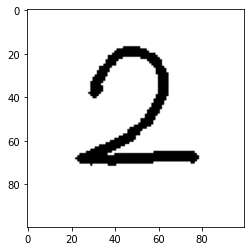

----------------예측 결과--------------------


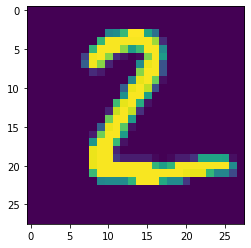

In [88]:
import cv2
import mediapipe as mp
import numpy as np
import sys

(i_train, j_train),(i_test, j_test) = mnist.load_data()
num_class = [i_test[10], i_test[2], i_test[1], i_test[30], i_test[24],
            i_test[15], i_test[21], i_test[0], i_test[61], i_test[16]]


sw = 0
sample = []
def draw_ball_location(img, locations):
    global sw
    
    if len(locations) == 0 and sw == 1:
        img = np.ones((100, 100, 3), np.uint8)*0
        sw = 0
    for i in range(len(locations)-1):
            
        cv2.line(img, tuple(locations[i]), 
                tuple(locations[i+1]), (255, 255, 255), 3)

    sample.append(img)
    return img

img = np.ones((100, 100, 3), np.uint8)*0


mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
 
cap = cv2.VideoCapture(0)


with mp_hands.Hands(
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    
    list_ball_location = []
    history_ball_locations = []
    isDraw = True
    while cap.isOpened():
        
        success, image = cap.read()
        
        
        if not success:
            continue
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
 
        results = hands.process(image)
 
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_hand_landmarks:

            for hand_landmarks in results.multi_hand_landmarks:
                
                finger2_1 = int(hand_landmarks.landmark[8].x*100 )
                finger2_2 = int(hand_landmarks.landmark[8].y*100 )

                cv2.putText(
                    image, text='f2_x=%d f2_y=%d ' % (finger2_1,
                                                          finger2_2), 
                    org=(10, 30),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                    color=255, thickness=3)
 
                mp_drawing.draw_landmarks(
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                if isDraw:
                    list_ball_location.append((finger2_1, finger2_2))

                else:
                    history_ball_locations.append(list_ball_location.copy())
                    list_ball_location.clear()
        
        img = draw_ball_location(img, list_ball_location)
        for ball_locations in history_ball_locations:
            img = draw_ball_location(img, ball_locations)
        
        
        cv2.imshow('img', img)
        cv2.imshow('image', image)
        key = cv2.waitKey(1)
        
        if key == 27: # esc
            break
        
        elif key == 32: # space bar
            print('32')
            list_ball_location.clear()
            history_ball_locations.clear()
            sw = 1
            
        
        elif key == ord('v'):
            isDraw = not isDraw

cv2.imwrite('save_image.jpg', img)           
cap.release()
cv2.destroyAllWindows()

## 그린것을 읽어와 만든 학습모델로 예측하기
img = cv2.imread('./save_image.jpg', cv2.IMREAD_GRAYSCALE)
dst = img
plt.imshow(dst, cmap = 'Greys')
plt.show()
plt.close()
data = dst.reshape(-1 , 100**2).astype('float32')/255
j = model.predict(data)
idx = np.argmax(j)

print('----------------예측 결과--------------------')
plt.imshow(num_class[idx])
plt.show()